In [1]:
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import

In [2]:
%matplotlib inline
%load_ext google.cloud.bigquery

---
### Using SQL Windowing

This is a nice way to take stats from events prior to the take off into consideration: Keep track of average and maximum departure delay in the hour before take off.

Certainly, these stats will only avaible at take-off time, but that may be come by using estimates using previous days, months, or even years.

In [3]:
%%bigquery window_stats
SELECT 
  AIRLINE, dep_t, dep_delay,
  avg(dep_delay) over ( order by dep_t range between 100 preceding and current row) as avg_dep_delay_hour_before,
  max(dep_delay) over ( order by dep_t range between 100 preceding and current row) as max_dep_delay_hour_before
FROM 
  `going-tfx.examples.ATL_JUNE_SIGNATURE` 
where 
  year=2002 and day=1
order by dep_t
limit 20

,AIRLINE,dep_t,dep_delay,avg_dep_delay_hour_before,max_dep_delay_hour_before
0,US,610,-7.0,-7.000000,-7.0
1,DL,620,2.0,14.000000,61.0
2,DL,620,0.0,14.000000,61.0
3,DL,620,61.0,14.000000,61.0
4,UA,627,-8.0,9.600000,61.0
5,DL,630,4.0,6.857143,61.0
6,DL,630,-4.0,6.857143,61.0
7,DL,635,-3.0,4.555556,61.0
8,DL,635,-4.0,4.555556,61.0
9,DL,640,-9.0,3.200000,61.0


---
#### Standard statistics
Study correlations by performing the typical dimension statistics

In [4]:
STATEMENT = """
with hodded as 
(select 
    YEAR, MONTH, DEP_DOW, AIRLINE,
    cast(FLOOR(DEP_T/100) as int64) as HOD, 
    AVG(DEP_DELAY) as avg_dep_delay,
    MAX(DEP_DELAY) as max_dep_delay
from 
    `examples.ATL_JUNE_SIGNATURE` 
group by
    YEAR, MONTH, DEP_DOW, HOD, AIRLINE
)
select 
    {0}, 
    AVG(avg_dep_delay) as avg_dep_delay, 
    MAX(max_dep_delay) as max_dep_delay
from 
    hodded
    {1}
group by 
    {0}
order by 
    {0}"""

import google.datalab.bigquery as dlbq
def flstats (by, **kwargs):
    """
        kwargs: airline=None, hod=None, month=None, year=None, dep_dow=None
    """
    def enc(value):
        if type(value) == int:
            return value
        elif type(value) == str:
            return "'%s'" % value    

    def where_clause(**as_dict):
        clause = " AND ".join([ "%s=%s"% (key.upper(), enc(as_dict[key])) for key in as_dict.keys()])    
        return "WHERE " + clause if len(as_dict) > 0 else ""
    
    where = where_clause(**kwargs)
    qstring = STATEMENT.format(by, where_clause(**kwargs))
    query = dlbq.Query(qstring)
    return query.execute().result().to_dataframe()

In [5]:
def disp_stats(by, **kwargs):
    res = flstats(by, **kwargs)
    res.plot.bar(x=by, y='max_dep_delay')
    res.plot.bar(x=by, y='avg_dep_delay')  

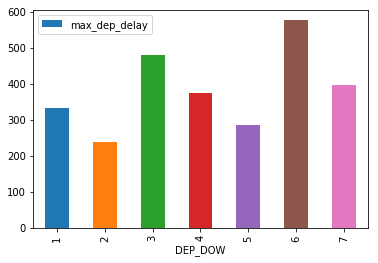

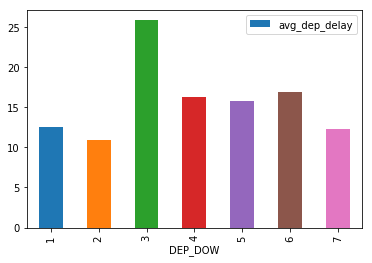

In [7]:
disp_stats('DEP_DOW', airline='DL', year=2010)

In [108]:
stats = dlbq.Query("""
select 
    YEAR, MONTH, DEP_DOW, AIRLINE,
    cast(FLOOR(DEP_T/100) as int64) as HOD, 
    AVG(DEP_DELAY) as avg_dep_delay,
    MAX(DEP_DELAY) as max_dep_delay
from 
    `examples.ATL_JUNE_SIGNATURE` 
group by
    YEAR, MONTH, DEP_DOW, HOD, AIRLINE
""").execute().result().to_dataframe()

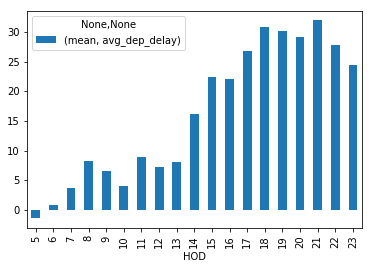

In [143]:
import pandas as pd
import numpy as np
filtered= stats[stats['DEP_DOW']==2]
pv = pd.pivot_table(filtered, index=['HOD'], values=['avg_dep_delay'], aggfunc=[np.mean], fill_value=0)
pv.plot.bar();

In [8]:
airlines = dlbq.Query("""
select 
    airline, count(*) as count
from 
    examples.ATL_JUNE_SIGNATURE
group by airline
""").execute().result().to_dataframe()

In [9]:
print({ d['airline']: d['count'] for d in airlines.to_dict(orient='records')})

{'AA': 5246, 'OO': 1658, 'DL': 135329, 'CO': 3203, 'DH': 298, 'OH': 5472, 'YV': 806, 'FL': 52549, 'HP': 597, '9E': 2920, 'AS': 60, 'US': 2881, 'XE': 1912, 'B6': 90, 'MQ': 364, 'F9': 656, 'EV': 81626, 'UA': 791, 'NW': 1871}


In [3]:
import google.datalab.bigquery as dlbq
flights = dlbq.Query("Select * from examples.ATL_JUNE_SIGNATURE").execute().result().to_dataframe()

In [4]:
len(flights)

298329

In [14]:
flights.head()

,DATE,YEAR,MONTH,DAY,DEP_DOW,AIRLINE_NAME,AIRLINE,DEP_T,DEP,DEP_LAT,...,WND_SPD_DEP,ARR_T,ARR_DELAY,ARR,ARR_LAT,ARR_LON,ARR_W,MEAN_TEMP_ARR,MEAN_VIS_ARR,WND_SPD_ARR
0,2002-06-01,2002,6,1,7,Delta Air Lines Inc.: DL,DL,820,ATL,33.63,...,6.9,1020,-19.0,PDX,45.58,-122.59,PORTLAND,61.9,9.9,7.7
1,2002-06-01,2002,6,1,7,Delta Air Lines Inc.: DL,DL,1915,ATL,33.63,...,6.9,2113,-12.0,PDX,45.58,-122.59,PORTLAND,61.9,9.9,7.7
2,2002-06-01,2002,6,1,7,Delta Air Lines Inc.: DL,DL,830,ATL,33.63,...,6.9,936,10.0,CHS,32.89,-80.04,CHARLESTON,79.5,9.3,5.8
3,2002-06-01,2002,6,1,7,Delta Air Lines Inc.: DL,DL,1125,ATL,33.63,...,6.9,1229,14.0,CHS,32.89,-80.04,CHARLESTON,79.5,9.3,5.8
4,2002-06-01,2002,6,1,7,Delta Air Lines Inc.: DL,DL,1425,ATL,33.63,...,6.9,1528,7.0,CHS,32.89,-80.04,CHARLESTON,79.5,9.3,5.8


In [ ]:
flights['MEAN_VIS_DEPTH']

In [5]:
flights.columns

Index([u'DATE', u'YEAR', u'MONTH', u'DAY', u'DEP_DOW', u'AIRLINE_NAME',
       u'AIRLINE', u'DEP_T', u'DEP', u'DEP_LAT', u'DEP_LON', u'DEP_DELAY',
       u'DEP_W', u'MEAN_TEMP_DEP', u'MEAN_VIS_DEP', u'WND_SPD_DEP', u'ARR_T',
       u'ARR_DELAY', u'ARR', u'ARR_LAT', u'ARR_LON', u'ARR_W',
       u'MEAN_TEMP_ARR', u'MEAN_VIS_ARR', u'WND_SPD_ARR'],
      dtype='object')

In [15]:
import seaborn as sns

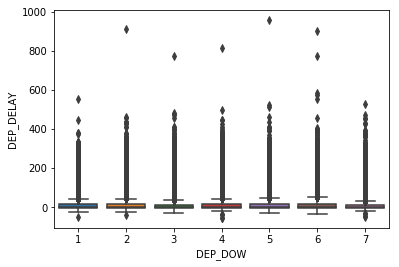

In [16]:
sns.boxplot(x='DEP_DOW', y='DEP_DELAY', data=flights)

In [46]:
import matplotlib.pyplot as plt

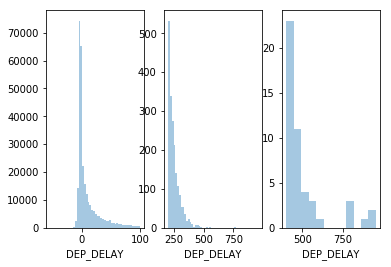

In [49]:
_, axes = plt.subplots(1,3, sharey=False, figsize=(6,4))
sns.distplot(flights[flights['DEP_DELAY'] <100]['DEP_DELAY'], kde=False, ax=axes[0])
sns.distplot(flights[flights['DEP_DELAY'] >200]['DEP_DELAY'], kde=False, ax=axes[1])
sns.distplot(flights[flights['DEP_DELAY'] >400]['DEP_DELAY'], kde=False, ax=axes[2]);

In [50]:
late_ones=flights[(flights['DEP_DELAY'] > 200)]
len(late_ones)

1938

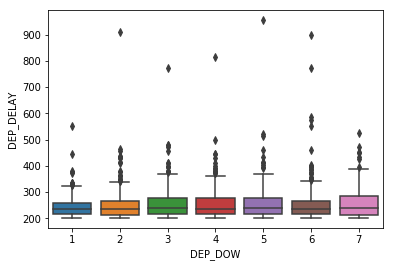

In [32]:
sns.boxplot(x='DEP_DOW', y='DEP_DELAY', data=late_ones)

In [26]:
flights[['MEAN_VIS_DEP', 'DEP_DELAY']].describe()

,MEAN_VIS_DEP,DEP_DELAY
count,298329.000000,298329.000000
mean,9.022412,15.331969
std,1.176153,36.612625
min,3.600000,-54.000000
25%,8.500000,-2.000000
50%,9.500000,1.000000
75%,9.900000,16.000000
max,10.000000,955.000000


In [59]:
def query(key):
    return """
    with 
    late_ones as (
        select {0} as al, count(*) as count_late from examples.ATL_JUNE_SIGNATURE 
        where dep_delay > 200 group by {0} order by {0}),
    all_flights as (
        select {0} as aa , count(*) as count_all from examples.ATL_JUNE_SIGNATURE 
        group by {0} order by {0})    
    select al as {0}, count_late as late, count_all as total_{0}, count_late/count_all*1000 as permill from 
    late_ones l join all_flights a on l.al = a.aa
    """.format(key)

In [64]:
res = dlbq.Query(query('WND_SPD_DEP')).execute().result().to_dataframe()

In [65]:
res

,WND_SPD_DEP,late,total_WND_SPD_DEP,permill
0,2.2,19,1156,16.435986
1,2.9,4,1083,3.693444
2,3.0,7,3416,2.049180
3,3.1,9,1716,5.244755
4,3.2,12,2137,5.615349
5,3.3,18,2100,8.571429
6,3.5,6,2779,2.159050
7,3.8,26,9226,2.818123
8,3.9,5,2531,1.975504
9,4.1,17,3197,5.317485


In [43]:
%%bigquery lateones
with 
late_ones as (
    select airline as al, count(airline) as count_late from examples.ATL_JUNE_SIGNATURE 
    where dep_delay > 200 group by airline order by airline),
all_flights as (
    select airline as aa , count(airline) as count_all from examples.ATL_JUNE_SIGNATURE 
    group by airline order by airline)    
select al as airline, count_late as late, count_all as total_airline, count_late/count_all as ratio from 
late_ones l join all_flights a on l.al = a.aa

,airline,late,total_airline,ratio
0,9E,8,2920,0.002740
1,AA,44,5246,0.008387
2,CO,58,3203,0.018108
3,DH,11,298,0.036913
4,DL,699,135329,0.005165
5,EV,613,81626,0.007510
6,F9,4,656,0.006098
7,FL,363,52549,0.006908
8,HP,4,597,0.006700
9,MQ,5,364,0.013736


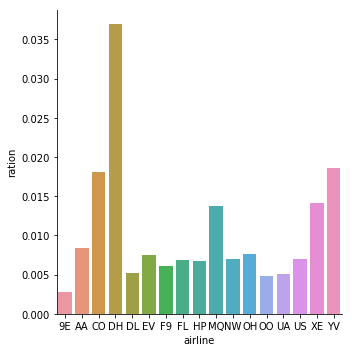

In [41]:
sns.catplot(x='airline', y='ration', data=lateones, kind='bar')

In [12]:
%%bigquery res
select approx_quantiles(dep_delay, 20) from examples.ATL_JUNE_SIGNATURE

,f0_
0,"[-54.0, -6.0, -5.0, -4.0, -3.0, -2.0, -2.0, -1..."


In [13]:
res['f0_'].iloc[0]

[-54.0,
 -6.0,
 -5.0,
 -4.0,
 -3.0,
 -2.0,
 -2.0,
 -1.0,
 0.0,
 0.0,
 1.0,
 2.0,
 4.0,
 7.0,
 11.0,
 16.0,
 23.0,
 34.0,
 51.0,
 88.0,
 955.0]